In [1]:
import pandas as pd
import numpy as np

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

# 노트북 안에 그래프를 그리기 위해
%matplotlib inline

# 그래프에서 격자로 숫자 범위가 눈에 잘 띄도록 ggplot 스타일을 사용
plt.style.use('ggplot')

# 그래프에서 마이너스 폰트 깨지는 문제에 대한 대처
mpl.rcParams['axes.unicode_minus'] = False

import warnings
warnings.filterwarnings('ignore')

In [2]:
train = pd.read_csv("train.csv", parse_dates=["datetime"])
train.shape

(10886, 12)

In [3]:
test = pd.read_csv("test.csv", parse_dates=["datetime"])
test.shape

(6493, 9)

In [4]:
#feature로 사용할 데이터만 데이터 프레임에 담아준다
train["year"] = train["datetime"].dt.year
train["month"] = train["datetime"].dt.month
train["hour"] = train["datetime"].dt.hour
train["dayofweek"] = train["datetime"].dt.dayofweek
train.shape

(10886, 16)

In [5]:
test["year"] = test["datetime"].dt.year
test["month"] = test["datetime"].dt.month
test["hour"] = test["datetime"].dt.hour
test["dayofweek"] = test["datetime"].dt.dayofweek
test.shape

(6493, 13)

In [6]:
# 연속형 feature와 범주형 feature
# 범주형 feature의 type을 category로 변경 해 준다.
categorical_feature_names = ["season","holiday","workingday","weather",
                             "dayofweek","month","year","hour"]

In [7]:
for var in categorical_feature_names:
    train[var] = train[var].astype("category")
    test[var] = test[var].astype("category")

In [8]:
feature_names = ["season", "weather", "temp", "atemp", "humidity",
                 "year", "hour", "dayofweek", "holiday", "workingday"
                ]

feature_names

['season',
 'weather',
 'temp',
 'atemp',
 'humidity',
 'year',
 'hour',
 'dayofweek',
 'holiday',
 'workingday']

In [9]:
#새로운 데이터프레임 생성
X_train = train[feature_names]

print(X_train.shape)
X_train.head()

(10886, 10)


,season,weather,temp,atemp,humidity,year,hour,dayofweek,holiday,workingday
0,1,1,9.84,14.395,81,2011,0,5,0,0
1,1,1,9.02,13.635,80,2011,1,5,0,0
2,1,1,9.02,13.635,80,2011,2,5,0,0
3,1,1,9.84,14.395,75,2011,3,5,0,0
4,1,1,9.84,14.395,75,2011,4,5,0,0


In [10]:
X_test = test[feature_names]

print(X_test.shape)
X_test.head()

(6493, 10)


,season,weather,temp,atemp,humidity,year,hour,dayofweek,holiday,workingday
0,1,1,10.66,11.365,56,2011,0,3,0,1
1,1,1,10.66,13.635,56,2011,1,3,0,1
2,1,1,10.66,13.635,56,2011,2,3,0,1
3,1,1,10.66,12.880,56,2011,3,3,0,1
4,1,1,10.66,12.880,56,2011,4,3,0,1


In [11]:
label_name = "count"

y_train = train[label_name]

print(y_train.shape)
y_train.head()

(10886,)


0    16
1    40
2    32
3    13
4     1
Name: count, dtype: int64

In [12]:
#RMSLE 방식으로 평가
#0에 가까울 수록 정확하다
from sklearn.metrics import make_scorer

def rmsle(predicted_values, actual_values, convertExp=True):

    if convertExp:
        predicted_values = np.exp(predicted_values),
        actual_values = np.exp(actual_values)

    # 넘파이로 배열 형태로 바꿔준다.
    predicted_values = np.array(predicted_values)
    actual_values = np.array(actual_values)

    # 예측값과 실제 값에 1을 더하고 로그를 씌워준다.
    log_predict = np.log(predicted_values + 1)
    log_actual = np.log(actual_values + 1)

    # 위에서 계산한 예측값에서 실제값을 빼주고 제곱을 해준다.
    difference = log_predict - log_actual
    difference = np.square(difference)

    # 평균을 낸다.
    mean_difference = difference.mean()

    # 다시 루트를 씌운다.
    score = np.sqrt(mean_difference)

    return score

# RMSLE
* 과대평가 된 항목보다는 과소평가 된 항목에 패널티를 준다.
* 오차(Error)를 제곱(Square)해서 평균(Mean)한 값의 제곱근(Root) 으로 값이 작을 수록 정밀도가 높다.
* 0에 가까운 값이 나올 수록 정밀도가 높은 값이다.
* 과대평가 된 항목보다 과소 평가 된 항목에 패널티를 주기위해 잔차(residual)에 대한 평균에 로그를 씌운 값이다.
* 정답에 대한 오류를 숫자로 나타낸 값으로 값이 클 수록 오차가 크다는 의미다.
* 값이 작을 수록 오류가 적다는 의미를 나타낸다.

In [13]:
#선형회귀 모델 Linear Regression Model
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
import warnings
pd.options.mode.chained_assignment = None
warnings.filterwarnings("ignore", category=DeprecationWarning)

# 선형회귀 모델을 초기화
lModel = LinearRegression()

# 모델을 학습시킨다.
# 1을 더한 수에 로그를 씌운다
y_train_log = np.log1p(y_train)
lModel.fit(X_train, y_train_log)

# 예측하고 정확도를 평가한다.
preds = lModel.predict(X_train)
print ("선형 회귀에 대한 RMSLE 값: ",
       rmsle(np.exp(y_train_log),np.exp(preds), False))

선형 회귀에 대한 RMSLE 값:  0.9803697923313499



* 선형회귀는 예측과 훈련 세트에 있는 타깃 y사이의 평균제곱오차(MSE)를 최소화하는 파라미터 w와 b를 찾는다

In [14]:
#릿지 Regularization Model - Ridge

ridge_m_ = Ridge()
#반복 실행하는 최대 횟수를 3000으로 넣어주고
#alpha값 들을 바탕으로 최적의 alpha값을 찾음
ridge_params_ = { 'max_iter':[3000],'alpha':[0.01, 0.1, 1, 2, 3, 4, 10, 30,100,200,300,400,800,900,1000]}
rmsle_scorer = metrics.make_scorer(rmsle, greater_is_better=False)
#GridSearchCV로 최적의 alpha값을 찾음
grid_ridge_m = GridSearchCV( ridge_m_,
                          ridge_params_,
                          scoring = rmsle_scorer,
                          cv=5)
#1를 더한 값에 로그를 사용한 값을 학습시킴
y_train_log = np.log1p(y_train)
grid_ridge_m.fit( X_train, y_train_log )
preds = grid_ridge_m.predict(X_train)
print (grid_ridge_m.best_params_)
print ("릿지 회귀에 대한 RMSLE 값: ", rmsle(np.exp(y_train_log),np.exp(preds), False))

{'alpha': 0.01, 'max_iter': 3000}
릿지 회귀에 대한 RMSLE 값:  0.9803697902780832


* 회기를 위한 선형 모델
* 가중치의 모든 원소가 0에 가깝게 만들어 모든 피처가 주는 영향을 최소화함으로 기울기를 작게 만음
* 오버피팅 되지 않도록 모델을 강제로 제한한다는 의미

In [15]:
#라쏘 Regularization Model - Lasso
lasso_m_ = Lasso()
#과소적합을 줄이기 위해서 alpha 계산
alpha  = 1/np.array([0.1, 1, 2, 3, 4, 10, 30,100,200,300,400,800,900,1000])
lasso_params_ = { 'max_iter':[3000],'alpha':alpha}

grid_lasso_m = GridSearchCV( lasso_m_,lasso_params_,scoring = rmsle_scorer,cv=5)
y_train_log = np.log1p(y_train)
grid_lasso_m.fit( X_train , y_train_log )
preds = grid_lasso_m.predict(X_train)
print (grid_lasso_m.best_params_)
print ("라쏘 회귀에 대한 RMSLE 값: ",rmsle(np.exp(y_train_log),np.exp(preds),False))


{'alpha': 0.00125, 'max_iter': 3000}
라쏘 회귀에 대한 RMSLE 값:  0.9803727821457646


* 선형회귀의 Regularization을 적용하는 대안
* 계수를 0에 가깝게 만들려고 하며 이를 L1규제라고고 한다
* 피처 선택이 자동으로 이루어 진다고도 볼 수 있다.
* alpha 값의 기본 값은 1.0이며 과소적합을 줄이기 위해서는 이 값을 줄여야함
* 그리드 서치로 아래 라쏘모델을 실행했을 때 베스트 알파값은 0.00125

In [16]:
#랜덤포레스트
from sklearn.ensemble import RandomForestRegressor
rfModel = RandomForestRegressor(n_estimators=100)

y_train_log = np.log1p(y_train)
rfModel.fit(X_train, y_train_log)

preds = rfModel.predict(X_train)
score = rmsle(np.exp(y_train_log),np.exp(preds),False)
print ("랜덤포레스트에 대한 RMSLE 값: ",score)

랜덤포레스트에 대한 RMSLE 값:  0.10761056287828534


* 여러 결정 트리를 묶어 과대적합을 회피할 수 있는 앙상블 방법
* 예측을 잘하는 트리를 평균을 내어서 과대적합을 줄인다
* 트리 생성시 무작위성을 주입하는데 트리 생성시 데이터 중 일부를 무작위로 선택하고 노드 분할 시 무작위로 후보 특성을 선택한다.
* 매개변수 튜닝 부담이 적고 데이터 스케일이 불필요하며 큰 데이터셋이 적용 가능함 등 많은 장점이 있다.
* n_estimators값이 높을 수록 예측을 하는데 시간이 오래걸리지만 정확도가 올라간다

In [17]:
#그래디언트 부스팅
from sklearn.ensemble import GradientBoostingRegressor
gbm = GradientBoostingRegressor(n_estimators=4000, alpha=0.01);

y_train_log = np.log1p(y_train)
gbm.fit(X_train, y_train_log)

preds = gbm.predict(X_train)
score = rmsle(np.exp(y_train_log),np.exp(preds),False)
print ("그래디언트 부스팅에 대한 RMSLE 값: ", score)

그래디언트 부스팅에 대한 RMSLE 값:  0.21357403727249374


* 여러개의 결정트리를 묶어 강력한 모델을 만드는 또 다른 앙상블 기법
* 회귀와 분류에 모두 사용할 수 있음
* 랜덤포레스트와 달리 이진 트리의 오차를 보완하는 방식으로 순차적으로 트리를 만든다.
* 무작위성이 없고 강력한 사전 가지치기가 사용 됨
* 1~5개의 깊지 않은 트리를 사용하기 때문에 메모리를 적게 사용하고 예측이 빠름
* n_estimator의 값을 키우면 앙상블에 트리가 더 많이 추가 되어 모델의 복잡도가 커지고 훈련세트에서의 실수를 바로잡을 기회가 많아지지만 너무 크면 모델이 복잡해지고 오버피팅(과대적합)이 될 수있다.

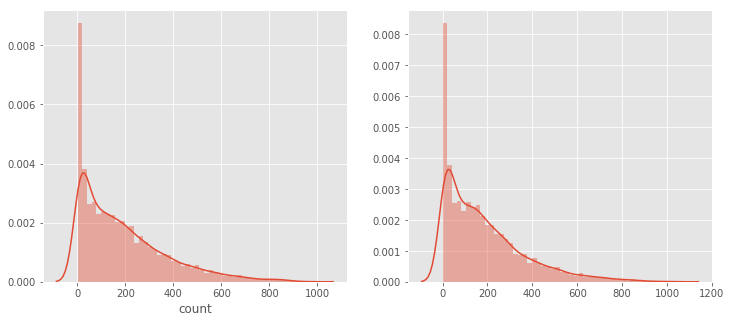

In [18]:
predsTest = gbm.predict(X_test)
fig,(ax1,ax2)= plt.subplots(ncols=2)
fig.set_size_inches(12,5)
sns.distplot(y_train,ax=ax1,bins=50)
sns.distplot(np.exp(predsTest),ax=ax2,bins=50)